Whale images

### Note: The code is setup in a way that you can easily run the notebook on colab with minimal changes
### TFRecords Dataset: https://www.kaggle.com/datasets/ks2019/happywhale-tfrecords-v4
### Code for generating TFRecords: https://www.kaggle.com/ks2019/happywhale-tfrecords

In [1]:
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 

True


In [2]:
import sys
import tensorflow as tf
import tensorflow.keras
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0

Python 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
GPU is NOT AVAILABLE


In [3]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [43]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

In [44]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

## Config

In [45]:
save_dir = '.'
EXPERIMENT = 0
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir = f'/content/drive/MyDrive/Kaggle/HappyWhale-2022/experiments-{EXPERIMENT}/{run_ts}'
    !mkdir -p {save_dir}

20220223-193547


In [46]:
class config:
    
    
    SEED = 42
    FOLD_TO_RUN = 0#In this notebook, we do not train models 
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 128
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 5
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 20
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 1000
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [47]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b5


In [48]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [49]:
GCS_PATH = 'gs://kds-d916c3252bf3bc5b3500b904f05f51ce57c8df85221d11b7711bcda9'  # Get GCS Path from kaggle notebook if GCS Path is expired
if not IS_COLAB:
    GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-b46d677ea558a164a3759b4081e497c09d42367357c6cc76bd802624
10 10 51033 27956


## Data

In [50]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

51033


2022-02-23 19:35:58.251569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 455 of 2048
2022-02-23 19:36:08.289095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 972 of 2048
2022-02-23 19:36:18.262953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1480 of 2048
2022-02-23 19:36:28.264171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1893 of 2048
2022-02-23 19:36:31.157997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


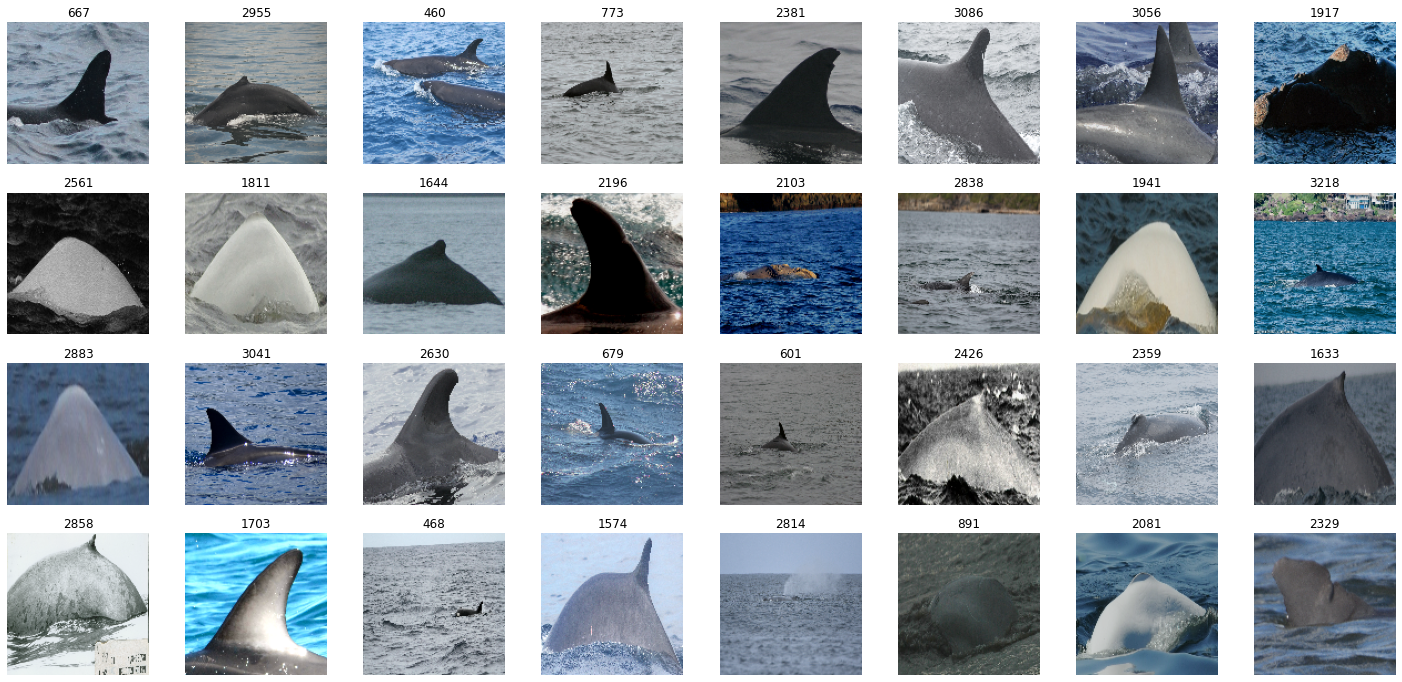

(32, 128, 128, 3)


In [51]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

27956


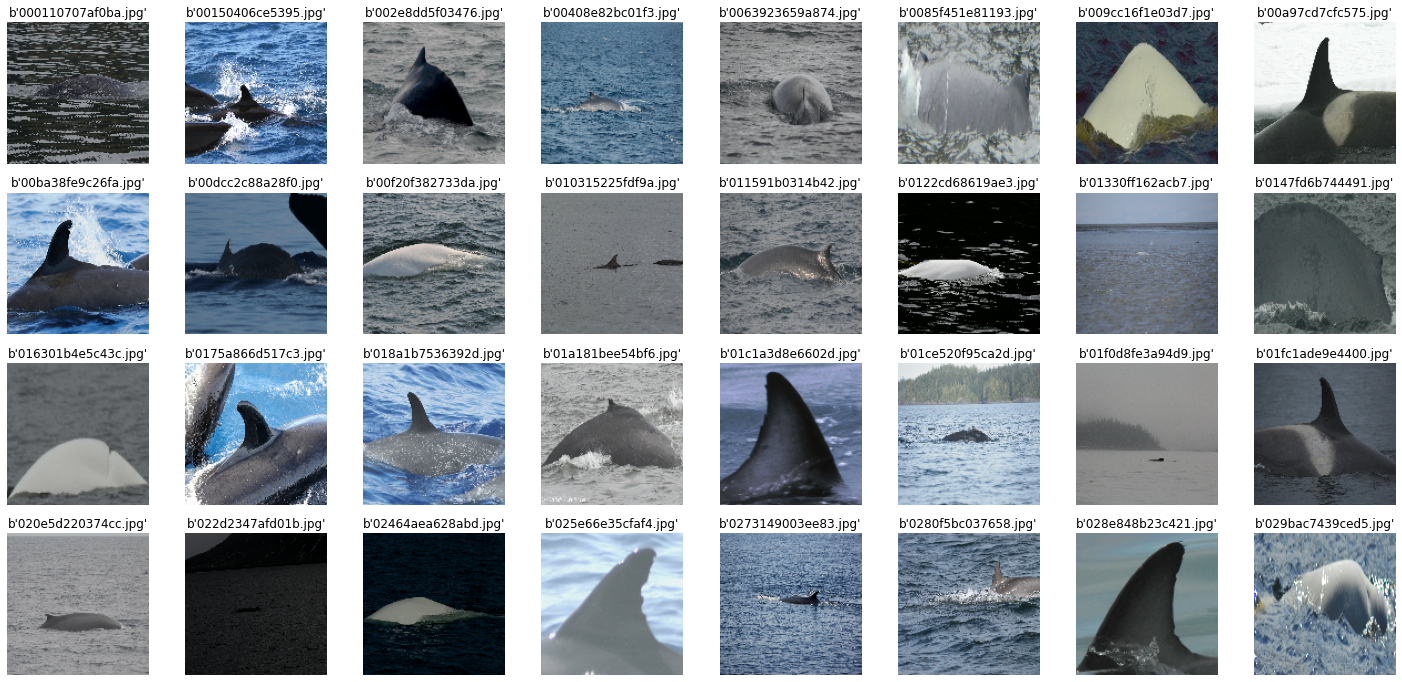

(32, 128, 128, 3)


In [52]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

## Model

In [53]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [54]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

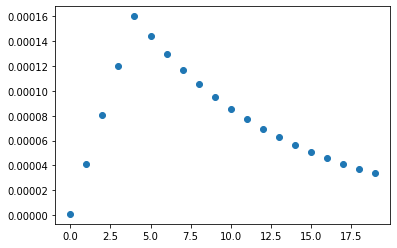

In [55]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [56]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Train

In [57]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 40826 10207


In [58]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [59]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, None, None, 2 28513520    inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           efficientnet-b5[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [60]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))
"""#In this notebook, we do not train models 
history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)
                
"""

#### Image Size 128 with EfficientNet B5 and batch_size 32


'#In this notebook, we do not train models \nhistory = model.fit(train_dataset,\n                validation_data = val_dataset,\n                steps_per_epoch = STEPS_PER_EPOCH,\n                epochs = config.EPOCHS,\n                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], \n                verbose = VERBOSE)\n                \n'

In [61]:
#with open(config.save_dir+f'train_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'rb') as f:


In [62]:
#model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss.h5")
#embed_models=[]
#for i in range(5):
 #   model,embed_model = get_model()
 #   embed_models.append((model.load_weights(f"../input/happywhale-arcface-eff5-768/effnetv1_b5_loss_{i}.h5"),embed_model))
    

In [63]:
import os

## Evaluation

In [64]:
def better_than_median(inputs, axis):
    """Compute the mean of the predictions if there are no outliers,
    or the median if there are outliers.

    Parameter: inputs = ndarray of shape (n_samples, n_folds)"""
    spread = inputs.max(axis=axis) - inputs.min(axis=axis) 
    spread_lim = 0.45
    print(f"Inliers:  {(spread < spread_lim).sum():7} -> compute mean")
    print(f"Outliers: {(spread >= spread_lim).sum():7} -> compute median")
    print(f"Total:    {len(inputs):7}")
    return np.where(spread < spread_lim,
                    np.mean(inputs, axis=axis),
                    np.median(inputs, axis=axis))

In [65]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(5)]), axis=0)
    #print (embeddings.shape)
    return embeddings

def get_embeddings_np(filename,data_types='train',kfold_list=[x for x in range(5)],dataset='../input/eff7-new-768'):#x for x in range(6)
    #ds = get_test_dataset([filename],get_names=False)
    #embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(5)]), axis=0)
    #print (embeddings.shape)
    val_train={'train':'val','val':'train','test':'test'}
    embeddings=[]
    for kfold in kfold_list:
        path=f'{dataset}/{data_types}_{filename.split("/")[-1]}_{kfold}.npy'
        if os.path.exists(path):
            print(path)
            with open(path, 'rb') as f:
                embeddings.append(np.load(f))
        else:
            path=f'{dataset}/{val_train[data_types]}_{filename.split("/")[-1]}_{kfold}.npy'
            if os.path.exists(path):
                print(path)
                with open(path, 'rb') as f:
                    embeddings.append(np.load(f))
                
                
    print (len(embeddings))
    embeddings = np.mean(np.stack(embeddings), axis=0)
    #embeddings = np.median(np.stack(embeddings), axis=0)
    #embeddings = better_than_median(np.stack(embeddings), axis=0)
    
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('../input/happywhale-splits/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [66]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):#TRAINING_FILENAMES
    embeddings = get_embeddings_np(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/8 [00:00<?, ?it/s]

../input/eff7-new-768/train_happywhale-2022-train-1-5104.tfrec_0.npy
../input/eff7-new-768/val_happywhale-2022-train-1-5104.tfrec_1.npy
../input/eff7-new-768/train_happywhale-2022-train-1-5104.tfrec_2.npy
../input/eff7-new-768/train_happywhale-2022-train-1-5104.tfrec_3.npy
../input/eff7-new-768/train_happywhale-2022-train-1-5104.tfrec_4.npy
5
../input/eff7-new-768/train_happywhale-2022-train-2-5104.tfrec_0.npy
../input/eff7-new-768/train_happywhale-2022-train-2-5104.tfrec_1.npy
../input/eff7-new-768/val_happywhale-2022-train-2-5104.tfrec_2.npy
../input/eff7-new-768/train_happywhale-2022-train-2-5104.tfrec_3.npy
../input/eff7-new-768/train_happywhale-2022-train-2-5104.tfrec_4.npy
5
../input/eff7-new-768/train_happywhale-2022-train-3-5103.tfrec_0.npy
../input/eff7-new-768/train_happywhale-2022-train-3-5103.tfrec_1.npy
../input/eff7-new-768/train_happywhale-2022-train-3-5103.tfrec_2.npy
../input/eff7-new-768/val_happywhale-2022-train-3-5103.tfrec_3.npy
../input/eff7-new-768/train_happywha

In [67]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=1000)

In [68]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):#(VALIDATION_FILENAMES):
    embeddings = get_embeddings_np(filename,'val')
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/2 [00:00<?, ?it/s]

../input/eff7-new-768/val_happywhale-2022-train-0-5104.tfrec_0.npy
../input/eff7-new-768/train_happywhale-2022-train-0-5104.tfrec_1.npy
../input/eff7-new-768/train_happywhale-2022-train-0-5104.tfrec_2.npy
../input/eff7-new-768/train_happywhale-2022-train-0-5104.tfrec_3.npy
../input/eff7-new-768/train_happywhale-2022-train-0-5104.tfrec_4.npy
5
../input/eff7-new-768/val_happywhale-2022-train-5-5103.tfrec_0.npy
../input/eff7-new-768/train_happywhale-2022-train-5-5103.tfrec_1.npy
../input/eff7-new-768/train_happywhale-2022-train-5-5103.tfrec_2.npy
../input/eff7-new-768/train_happywhale-2022-train-5-5103.tfrec_3.npy
../input/eff7-new-768/train_happywhale-2022-train-5-5103.tfrec_4.npy
5


In [69]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2177
37c7aba965a5        79
114207cab555        40
e69d5f9f8d1e        33
ffbb4e585ff2        32
                  ... 
43562941f4de         1
ac28317ce07c         1
7154d2fa1232         1
7a506ea20217         1
cd52cc0477be         1
Name: target, Length: 3255, dtype: int64

In [70]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10207 [00:00<?, ?it/s]

395    42
433    41
404    39
348    38
374    36
       ..
140     1
763     1
755     1
747     1
775     1
Name: image, Length: 634, dtype: int64

In [71]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.0: 0.8365402828124461


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.1: 0.8365402828124461


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.2: 0.8365402828124461


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.8366382547924598


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.4: 0.8409000359230566


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.5: 0.8925312693902855


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.9014957055615409


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.8510401358544764


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.8: 0.766882205022694


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.9: 0.6518631004865922


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 1.0: 0.5828418405669301


In [72]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.6000000000000001
Best cv 0.9014957055615409


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
count,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000
mean,0.836540,0.836540,0.836540,0.836638,0.840900,0.892531,0.901496,0.851040,0.766882,0.651863,0.582842
std,0.277483,0.277483,0.277483,0.277453,0.276086,0.253317,0.248060,0.272538,0.290176,0.273597,0.237786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8030, True: 2177}
best_threshold 0.5


is_new_individual,False,True,adjusted_cv
0.0,0.927779,0.500000,0.885001
0.1,0.927779,0.500000,0.885001
0.2,0.927779,0.500000,0.885001
0.3,0.927779,0.500459,0.885047
0.4,0.927530,0.521360,0.886913
0.5,0.919871,0.791686,0.907053
0.6,0.881640,0.974736,0.890949
0.7,0.811403,0.997244,0.829987
0.8,0.703807,0.999541,0.733380
0.9,0.557480,1.000000,0.601732


## Inference

In [74]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 2048) (51033,)


In [75]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=1000)

In [76]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    embeddings = get_embeddings_np(filename,'test')
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

../input/eff7-new-768/test_happywhale-2022-test-0-2796.tfrec_0.npy
../input/eff7-new-768/test_happywhale-2022-test-0-2796.tfrec_1.npy
../input/eff7-new-768/test_happywhale-2022-test-0-2796.tfrec_2.npy
../input/eff7-new-768/test_happywhale-2022-test-0-2796.tfrec_3.npy
../input/eff7-new-768/test_happywhale-2022-test-0-2796.tfrec_4.npy
5
../input/eff7-new-768/test_happywhale-2022-test-1-2796.tfrec_0.npy
../input/eff7-new-768/test_happywhale-2022-test-1-2796.tfrec_1.npy
../input/eff7-new-768/test_happywhale-2022-test-1-2796.tfrec_2.npy
../input/eff7-new-768/test_happywhale-2022-test-1-2796.tfrec_3.npy
../input/eff7-new-768/test_happywhale-2022-test-1-2796.tfrec_4.npy
5
../input/eff7-new-768/test_happywhale-2022-test-2-2796.tfrec_0.npy
../input/eff7-new-768/test_happywhale-2022-test-2-2796.tfrec_1.npy
../input/eff7-new-768/test_happywhale-2022-test-2-2796.tfrec_2.npy
../input/eff7-new-768/test_happywhale-2022-test-2-2796.tfrec_3.npy
../input/eff7-new-768/test_happywhale-2022-test-2-2796.tfr

In [77]:
sample_submission = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

425    99
436    99
423    99
400    99
394    98
       ..
733     1
765     1
797     1
766     1
767     1
Name: image, Length: 712, dtype: int64

In [78]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [79]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:#best_threshold_adjusted
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,d846a86edded63.jpg,03a3bbaeed84 new_individual a977dca03f23 4b6a2...
1,7a785b700b0339.jpg,c93996835aa8 new_individual d36d5a07500f 76afa...
2,50df0a954eb94c.jpg,713eb1a00c3d new_individual 8c78e0a8abee 9a8be...
3,7d0f46dd5f4108.jpg,982224d06f8c new_individual 3d5a4dd24d21 f63a9...
4,0f167a46fa2688.jpg,6989dcf1533f new_individual bb9890db1425 a5162...


In [80]:
print (test_df)

                       image        target  confidence
0         d846a86edded63.jpg  03a3bbaeed84    0.993715
1         7a785b700b0339.jpg  c93996835aa8    0.992472
2         50df0a954eb94c.jpg  713eb1a00c3d    0.991354
3         7d0f46dd5f4108.jpg  982224d06f8c    0.989391
4         0f167a46fa2688.jpg  6989dcf1533f    0.989248
...                      ...           ...         ...
11133012  523de940d9612e.jpg  b35310da97be    0.125837
11133013  523de940d9612e.jpg  d17c4bd8ba9c    0.125832
11133014  523de940d9612e.jpg  9936dd73e386    0.125810
11133015  523de940d9612e.jpg  7fc1cc251077    0.125757
11133016  523de940d9612e.jpg  7f1d3e4377b9    0.125743

[11133017 rows x 3 columns]
